<a href="https://colab.research.google.com/github/0201shj/CNN-Daisy-Dandelion/blob/main/pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [ ]:
!unzip flower.zip

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [9]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (1275, 150, 150, 3) 	Validation dataset shape: (364, 150, 150, 3)


In [10]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [11]:
batch_size = 50
num_classes = 2
epochs = 100
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['daisy', 'dandelion', 'dandelion', 'daisy', 'dandelion'] [0 1 1 0 1]


In [12]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()


58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [13]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff2cc226be0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff2cc1eb198>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff2cc1ebd30>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff2cb9cc4e0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff2cb9ca588>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff2cb9ccb70>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff2747868d0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff27478e828>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff27478ea20>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff274792f60>,block3_conv3,False


In [14]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


(1, 4, 4, 512)


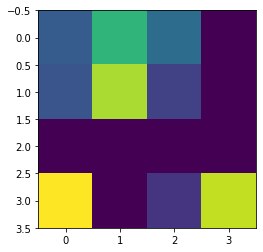

In [15]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [16]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [17]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (1275, 8192) 	Validation Bottleneck Features: (364, 8192)


In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,227,713
Trainable params: 4,227,713
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6023 - accuracy: 0.7009 - val_loss: 0.4289 - val_accuracy: 0.8077
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 0.3466 - accuracy: 0.8434 - val_loss: 0.3211 - val_accuracy: 0.8681
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 0.3055 - accuracy: 0.8591 - val_loss: 0.3292 - val_accuracy: 0.8516
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 0.2763 - accuracy: 0.8755 - val_loss: 0.3806 - val_accuracy: 0.8132
Epoch 5/100
26/26 [==============================] - 0s 11ms/step - loss: 0.2066 - accuracy: 0.9204 - val_loss: 0.3343 - val_accuracy: 0.8654
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 0.1738 - accuracy: 0.9292 - val_loss: 0.3961 - val_accuracy: 0.8516
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 0.1717 - accuracy: 0.9201 - val_loss: 0.3097 - val_accuracy: 0.8819
Epoch 8/100

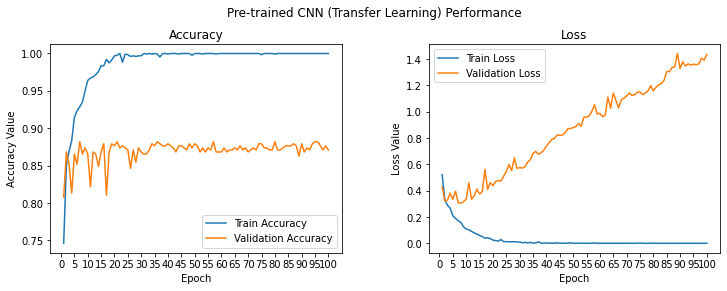

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [22]:
model.save('1_pretrained_cnn.h5')